In [11]:
%load_ext autoreload

%autoreload 2
from multiprocessing import Pool
import matplotlib.pyplot as plt
import pickle
from astropy.coordinates import SkyCoord, match_coordinates_3d, match_coordinates_sky
import sys
import emcee
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack
from astropy import units as u
import corner
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value

sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
import CL_WL_miscentering as mis
import analysis_Mass_Richness_relation as analysis
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_DATAOPS_match_catalogs as match
import CL_Mass_richness_relation as mr
import CL_Likelihood_for_Mass_richness_relation_v2 as likelihood_mr


import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
import astropy.units as un
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl

def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

In [13]:
data = np.load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/notebooks/data_for_notebooks/stacked_esd_profiles_redmapper_true.pkl', allow_pickle=True)
profiles = data['stacked profile']
covariances = data['stacked covariance']
print(len(profiles))

#model

16


In [14]:
clmm.__version__

'1.1.9'

In [15]:
MR_modeling = mr.WL_Mass_Richness()
MR_modeling.set_pivot_values(analysis.z0, analysis.richness0)

#modeling of the unitary excess surface density profile
def esd_modeling(R, log10m, c, z, cosmo):
    return clmm.compute_excess_surface_density(R, 10**log10m, c, z, cosmo, delta_mdef=200,
                                       halo_profile_model='nfw', massdef='critical')
def esd_modeling_2h_nobias(R, z):
    moo = clmm.Modeling(massdef='critical', delta_mdef=200, halo_profile_model='nfw')
    moo.set_cosmo(cosmo)
    return moo.eval_excess_surface_density_2h(R, z, halobias=1)

In [32]:
R = np.linspace(1, 10, 10)
y1 = esd_modeling(R, 14, 4, .3, cosmo)
y2 = esd_modeling_2h_nobias(R, .3)

[]

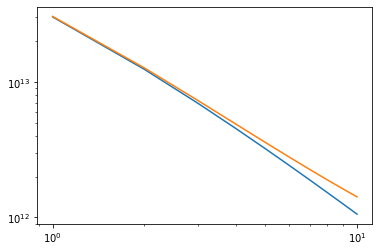

In [37]:
plt.plot(R, y1)
plt.plot(R, y1 + 1*y2)
plt.loglog()

In [17]:
esd_modeling_2h_nobias(, .2)

array([2.15431383e+11])

In [18]:
#defining the likelihood
lnL = likelihood_mr.MR_from_Stacked_ESD_profiles(richness_individual = profiles['richness'], 
                                                   z_individual = profiles['redshift'], 
                                                   weights_per_bin_individual = profiles['W_l_true'],
                                                   covariance_stack = covariances['cov_t'], 
                                                   esd_stack = profiles['gt'],
                                                   radius_stack = profiles['radius'],
                                                   MRR_object = MR_modeling, esd_modeling = esd_modeling, cosmo = cosmo)


#reshape data 
lnL.reshape_data(r_min = 1, r_max = 5.5)

#define likelihood

In [19]:
lnL.halo_regime(two_halo = True, esd_2h_nobias_modeling = esd_modeling_2h_nobias, c_m_relation = 'Diemer15')

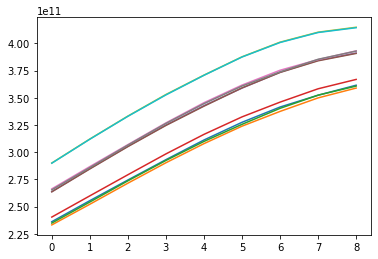

In [39]:
for i in range(10):
    plt.plot(lnL.esd_2h_nobias[i, :])

In [28]:
def lnLikelihood(p):
    logm0, G, F, sigma_int = p
    
    #prior
    if logm0 < 11: return -np.inf
    if sigma_int < 0: return -np.inf
    if sigma_int > 1: return -np.inf

    return lnL.lnLikelihood(p, which='full', scatter_lnc=.2, c_m_relation = 'Diemer15', two_halo_term=True)